## PyTorchでAttention Seq2Seqを実装

#### Attentionの仕組み
#### Seq2Seqの課題
Seq2SeqはEncoderがインプットの系列の長さによらず、固定長ベクトルに変換してしまうので、長い系列などは特徴が捉えきれない、という課題があります。
Attentionは、この課題を解決すべく、Encoder側のインプットの系列の長さを考慮できる仕組みを用意します。

Attentionの説明

1. Encoder側の各隠れ層の値をすべてDecoder側の各層に渡す
2. Decoder側の各層において、Encoder側から渡された各隠れ層のベクトルのうち、最も注意すべきベクトルを選び出して特徴に加える

という操作をします。
1.において、Encoder側の隠れ層ベクトルの数は、Encoder側のインプットとなる系列の長さに依存するので、系列の長さを考慮した形になっている
2.において、選び出すという操作は微分できないが、各要素のどこに注意すべきかをsoftmaxsoftmaxで確率的に重み付けした形で選ぶ操作を行います。



In [1]:
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle

# date.txtのパス
file_path = "../data/date.txt"

input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

# date.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(file_path, "r") as f:
    date_list = f.readlines()
    for date in date_list:
        date = date[:-1]
        input_date.append(date.split("_")[0])
        output_date.append("_" + date.split("_")[1])

# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0]) # 29
output_len = len(output_date[0]) # 10

# date.txtで登場するすべての文字にIDを割り当てる
char2id = {}
for input_chars, output_chars in zip(input_date, output_date):
    for c in input_chars:
        if not c in char2id:
            char2id[c] = len(char2id)
    for c in output_chars:
        if not c in char2id:
            char2id[c] = len(char2id)

input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
    input_data.append([char2id[c] for c in input_chars])
    output_data.append([char2id[c] for c in output_chars])

# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

# データをバッチ化するための関数を定義
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
        input_batch.append(input_shuffle[i:i+batch_size])
        output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

#### Encoder
- Encoder側はほとんど前回実装したseq2seqから変わりません。
- 少しでも楽したいので、LSTMはGRUに変えてます。
- GRUの各隠れ層の値はDecoder側でAttentionされるために使うので、GRUの第１戻り値(hshs)も受け取ってます。

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# 諸々のパラメータなど
embedding_dim = 200
hidden_dim = 128
BATCH_NUM = 100
vocab_size = len(char2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # hsが各系列のGRUの隠れ層のベクトル
        # Attentionされる要素
        hs, h = self.gru(embedding)
        return hs, h

#### Decoder
- こっちもEncoder側と同様に前回と比べてLSTMをGRUに変えてます。
- 紙とかに各層のテンソルのどの軸がなんの意味なのかを書きながら実装すると頭が整理できます。
- 少しでも理解の助けになるためにAttention層の各テンソルのサイズも記載してみました。

In [3]:
# Attention Decoderクラス
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # hidden_dim*2としているのは、各系列のGRUの隠れ層とAttention層で計算したコンテキストベクトルをtorch.catでつなぎ合わせることで長さが２倍になるため
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        # 列方向を確率変換したいのでdim=1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)

       # Attention層
       # hs.size() = ([100, 29, 128])
       # output.size() = ([100, 10, 128])

       # bmmを使ってEncoder側の出力(hs)とDecoder側の出力(output)をbatchごとまとめて行列計算するために、Decoder側のoutputをbatchを固定して転置行列を取る
        t_output = torch.transpose(output, 1, 2) # t_output.size() = ([100, 128, 10])

        # bmmでバッチも考慮してまとめて行列計算
        s = torch.bmm(hs, t_output) # s.size() = ([100, 29, 10])

        # 列方向(dim=1)でsoftmaxをとって確率表現に変換
        # この値を後のAttentionの可視化などにも使うため、returnで返しておく
        attention_weight = self.softmax(s) # attention_weight.size() = ([100, 29, 10])

        # コンテキストベクトルをまとめるために入れ物を用意
        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device) # c.size() = ([100, 1, 128])

        # 各DecoderのGRU層に対するコンテキストベクトルをまとめて計算する方法がわからなかったので、
        # 各層（Decoder側のGRU層は生成文字列が10文字なので10個ある）におけるattention weightを取り出してforループ内でコンテキストベクトルを１つずつ作成する
        # バッチ方向はまとめて計算できたのでバッチはそのまま
        for i in range(attention_weight.size()[2]): # 10回ループ

            # attention_weight[:,:,i].size() = ([100, 29])
            # i番目のGRU層に対するattention weightを取り出すが、テンソルのサイズをhsと揃えるためにunsqueezeする
            unsq_weight = attention_weight[:,:,i].unsqueeze(2) # unsq_weight.size() = ([100, 29, 1])

            # hsの各ベクトルをattention weightで重み付けする
            weighted_hs = hs * unsq_weight # weighted_hs.size() = ([100, 29, 128])

            # attention weightで重み付けされた各hsのベクトルをすべて足し合わせてコンテキストベクトルを作成
            weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1) # weight_sum.size() = ([100, 1, 128])

            c = torch.cat([c, weight_sum], dim=1) # c.size() = ([100, i, 128])

        # 箱として用意したzero要素が残っているのでスライスして削除
        c = c[:,1:,:]

        output = torch.cat([output, c], dim=2) # output.size() = ([100, 10, 256])
        output = self.hidden2linear(output)
        return output, state, attention_weight

#### モデル宣言、損失関数、最適化

In [4]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
attn_decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, BATCH_NUM).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
attn_decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=0.001)

#### 学習
- Encoderのアウトプットであるhshsを忘れずにAttention Decoderに渡せばOK
- EncoderもDecoderもインプットとアウトプットに変更がないので、ほとんど前回のSeq2Seqのときと同じでOK
- ものすごい勢いでlossが減っていきます
- 以下ではlossの下限を0.1に設定してますが、16epoch目にしてもう到達してしまいます。

In [5]:
BATCH_NUM=100
EPOCH_NUM = 40

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0
    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)
    for i in range(len(input_batch)):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        attn_decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        # Encoderの順伝搬
        hs, h = encoder(input_tensor)

        # Attention Decoderのインプット
        source = output_tensor[:, :-1]

        # Attention Decoderの正解データ
        target = output_tensor[:, 1:]

        loss = 0
        decoder_output, _, attention_weight= attn_decoder(source, hs, h)
        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        encoder_optimizer.step()
        attn_decoder_optimizer.step()

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 0.1: break
print("Done")

training ...
Epoch 1: 1799.29
Epoch 2: 74.98
Epoch 3: 21.13
Epoch 4: 7.32
Epoch 5: 14.45
Epoch 6: 3.48
Epoch 7: 8.38
Epoch 8: 3.40
Epoch 9: 1.35
Epoch 10: 0.88
Epoch 11: 0.62
Epoch 12: 0.46
Epoch 13: 0.34
Epoch 14: 0.27
Epoch 15: 0.21
Epoch 16: 0.17
Epoch 17: 0.14
Epoch 18: 0.11
Epoch 19: 0.09
Done


#### 損失可視化

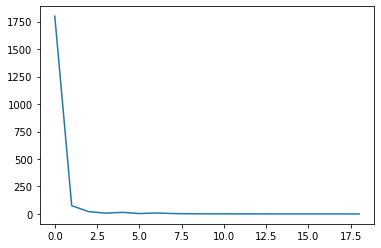

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_losses)

#### 予測

In [7]:
import pandas as pd

# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
    results = []
    for h in decoder_output:
        results.append(torch.argmax(h))
    return torch.tensor(results, device=device).view(BATCH_NUM, 1)

# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

predicts = []
for i in range(len(test_input_batch)):
    with torch.no_grad():
        hs, encoder_state = encoder(input_tensor[i])

    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    decoder_hidden = encoder_state
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    for _ in range(output_len - 1):
        decoder_output, decoder_hidden, _ = attn_decoder(decoder_input_tensor, hs, decoder_hidden)
        # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
        decoder_input_tensor = get_max_index(decoder_output.squeeze())
        batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
    predicts.append(batch_tmp[:,1:])


# 予測結果を見る際にIDのままだと可読性が悪いので、もとの文字列に復元するためのID→文字列に変換する辞書を定義
id2char = {}
for k, v in char2id.items():
    id2char[v] = k

row = []
for i in range(len(test_input_batch)):
    batch_input = test_input_batch[i]
    batch_output = test_output_batch[i]
    batch_predict = predicts[i]
    for inp, output, predict in zip(batch_input, batch_output, batch_predict):
        x = [id2char[idx] for idx in inp]
        y = [id2char[idx] for idx in output[1:]]
        p = [id2char[idx.item()] for idx in predict]

    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)

    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])
predict_df.head()

,input,answer,predict,judge
0,6/24/03,2003-06-24,2003-06-24,O
1,"september 19, 1991",1991-09-19,1991-09-19,O
2,"apr 14, 2014",2014-04-14,2014-04-14,O
3,"dec 15, 1992",1992-12-15,1992-12-15,O
4,"saturday, august 23, 2008",2008-08-23,2008-08-23,O


#### 正解率

In [11]:
print(len(predict_df.query('judge == "O"')) / len(predict_df))
predict_df.query('judge == "X"').head(10)

1.0


,input,answer,predict,judge


#### attention weight 可視化
- Attentionの醍醐味の1つであるattention weightの可視化をしてみます。
- attention weightを見ることで学習の確からしさを確認することができます。
- attention weightの可視化にはよくheatmapが使われるので、seabornのheatmapで可視化してます。
- 7:3に分けた3のほうのテストデータをバッチに分けたうちの最初のミニバッチを流しています。

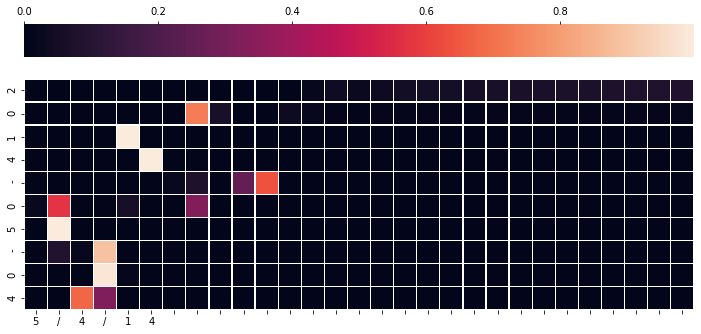

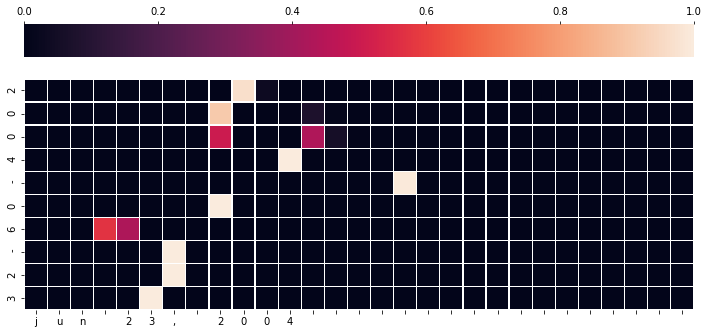

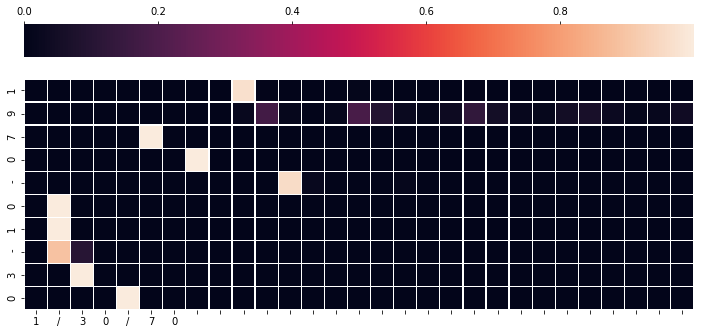

In [9]:
import seaborn as sns
import pandas as pd

input_batch, output_batch = train2batch(test_x, test_y, batch_size=BATCH_NUM)
input_minibatch, output_minibatch = input_batch[0], output_batch[0]

with torch.no_grad():
    # データをテンソルに変換
    input_tensor = torch.tensor(input_minibatch, device=device)
    output_tensor = torch.tensor(output_minibatch, device=device)
    hs, h = encoder(input_tensor)
    source = output_tensor[:, :-1]
    decoder_output, _, attention_weight= attn_decoder(source, hs, h)


for i in range(3):
    with torch.no_grad():
        df = pd.DataFrame(data=torch.transpose(attention_weight[i], 0, 1).cpu().numpy(), 
                          columns=[id2char[idx.item()] for idx in input_tensor[i]], 
                          index=[id2char[idx.item()] for idx in output_tensor[i][1:]])
        plt.figure(figsize=(12, 8)) 
        sns.heatmap(df, xticklabels = 1, yticklabels = 1, square=True, linewidths=.3,cbar_kws = dict(use_gridspec=False,location="top"))